# Phase 2 Group 1 Project

## Overview

## Business Problem

## Data Understanding

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import OLSInfluence as influence

## Review the Data File

In [2]:
#read in the file
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
#check the first 5 entries in the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#check the columns and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Cleaning the Data

In [5]:
#for year renovated, convert any houses that have been renovated to '1' to indicate true
#for any nulls, assume no renovation
df['yr_renovated'].fillna(0, inplace=True)
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else x)

In [6]:
df.rename(columns={'yr_renovated': 'if_renovated'}, inplace=True)

In [7]:
#for any nulls, assume no waterfront
df['waterfront'].fillna(0, inplace=True)

In [8]:
#for any nulls, assume no one viewed the property
df['view'].fillna(0, inplace=True)

In [9]:
#clean up sqft_basement and convert to int
df['sqft_basement'] = df['sqft_basement'].replace({'?':np.nan}).astype(float)
df['sqft_basement'].fillna(df['sqft_living']-df['sqft_above'], inplace=True)

In [10]:
#retrieve the months and year
df['month_of_date'] = pd.DatetimeIndex(df['date']).month
df['year_of_date'] = pd.DatetimeIndex(df['date']).year

In [11]:
#convert yr_built to age of house by subtracting year the property was sold by the year it was built
#to create a more sensible column 
df['age_of_house'] = df['year_of_date'] - df['yr_built']

#drop year of date because years are only 2014 and 2015, and will not impact our predicative model
#drop yr_built b/c it is redundant with age_of_house
df.drop(columns=['year_of_date'], inplace=True)
df.drop(columns=['yr_built'], inplace=True)

In [12]:
#drop duplicates if any
df.drop_duplicates(inplace=True)

In [13]:
#drop id and date columns
df.drop(columns=['id'], inplace=True)
df.drop(columns=['date'], inplace=True)

In [14]:
#reset index
df.reset_index(inplace=True, drop=True)

In [15]:
#convert some of the categorical data from floats to ints
df['waterfront'] = df['waterfront'].astype(int)
df['view'] = df['view'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(int)
df['if_renovated'] = df['if_renovated'].astype(int)

In [16]:
#check cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int64  
 12  if_renovated   21597 non-null  int64  
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  month_

In [17]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,if_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_of_date,age_of_house
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,0,98178,47.5112,-122.257,1340,5650,10,59
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1,98125,47.7210,-122.319,1690,7639,12,63
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,0,98028,47.7379,-122.233,2720,8062,2,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,0,98136,47.5208,-122.393,1360,5000,12,49
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,0,98074,47.6168,-122.045,1800,7503,2,28


## EDA

### Target: Price

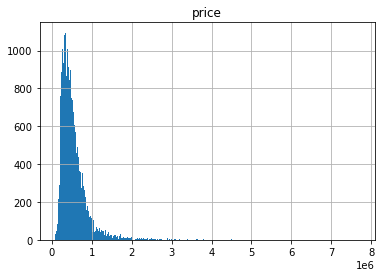

In [18]:
#Since price is our target, we will explore first
#view distribution of price using histogram
df.hist(column=['price'], bins='auto');

<AxesSubplot:>

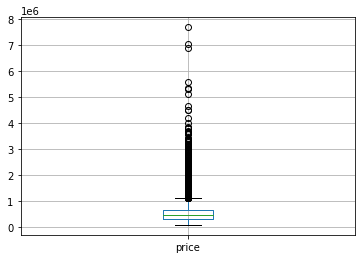

In [19]:
df.boxplot(column=['price'])

In [20]:
#Because the data is skewed to the right, transform the price data using log
df['ln_price'] = np.log(df['price'])

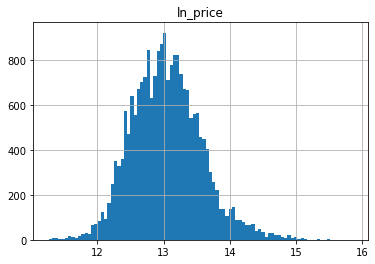

In [21]:
#view distribution of log base e for price using histogram
df.hist(column=['ln_price'], bins='auto');

<AxesSubplot:>

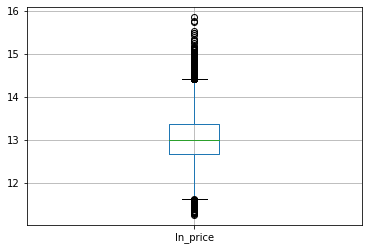

In [22]:
df.boxplot(column=['ln_price'])

### Predictors: Everything Else

In [23]:
#sns.pairplot(df)

In [24]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'if_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month_of_date', 'age_of_house',
       'ln_price'],
      dtype='object')

In [25]:
#based on the pairplot, we can see which data are categorical and which are numeric
numeric = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           'sqft_basement',
           'lat', 
           'long',
           'sqft_living15', 
           'sqft_lot15']

categorical = ['floors',
               'waterfront', 
               'view', 
               'condition', 
               'grade',
               'if_renovated',
               'zipcode',
               'month_of_date']

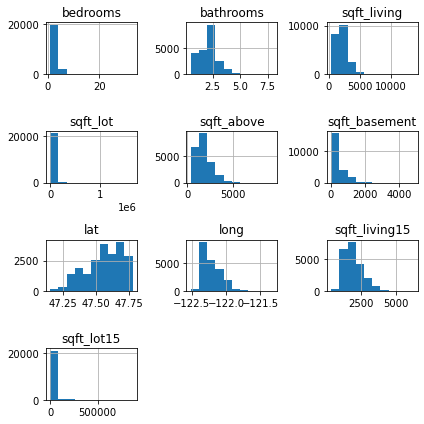

In [26]:
#plot the numeric parameters to see distribution
df[numeric].hist(figsize=[6,6]);
plt.tight_layout()
plt.show()

In [27]:
#log transform all numeric parameter except:
#sqft basement - has values of 0
#long - has negative values
to_ln = ['bedrooms',
         'bathrooms',
         'sqft_living',
         'sqft_lot', 
         'sqft_above',
         'lat',
         'sqft_living15', 
         'sqft_lot15']

for column in to_ln:
    df[column] = np.log(df[column])

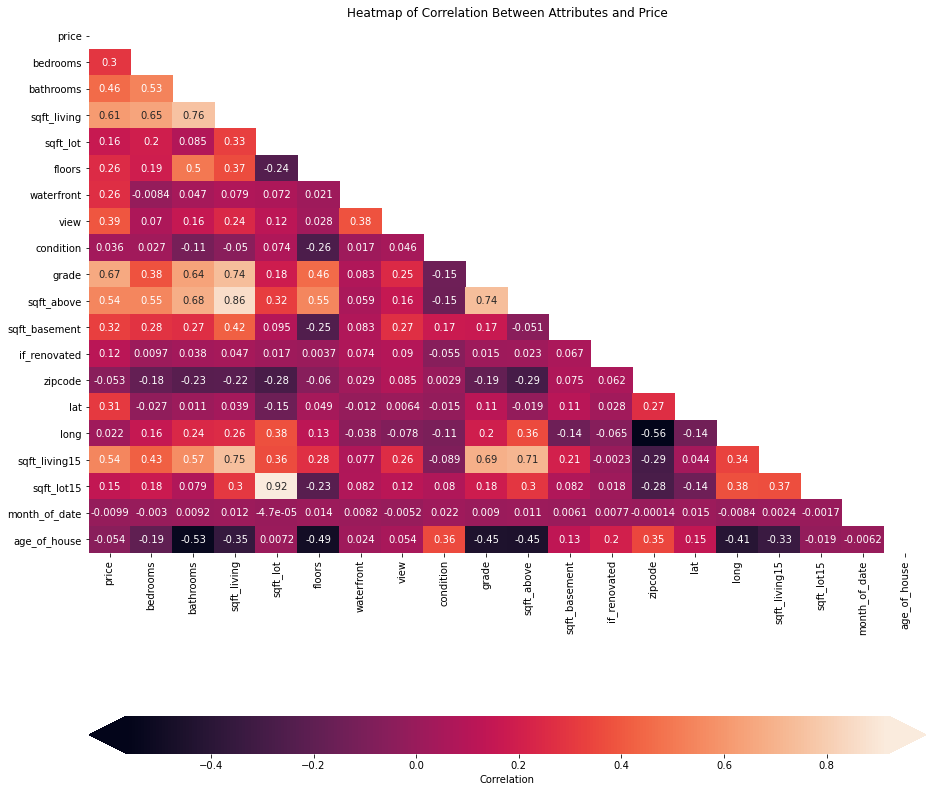

In [28]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
y = df['price']
heatmap_data = pd.concat([y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [29]:
#reporting the correlation between price (target) and predictors
df.corr()['price'].drop(['ln_price']).map(abs).sort_values(ascending=False)

price            1.000000
grade            0.667951
sqft_living      0.611839
sqft_living15    0.543829
sqft_above       0.542675
bathrooms        0.456122
view             0.393497
sqft_basement    0.323799
lat              0.306954
bedrooms         0.298844
waterfront       0.264306
floors           0.256804
sqft_lot         0.161561
sqft_lot15       0.147913
if_renovated     0.117543
age_of_house     0.053890
zipcode          0.053402
condition        0.036056
long             0.022036
month_of_date    0.009928
Name: price, dtype: float64

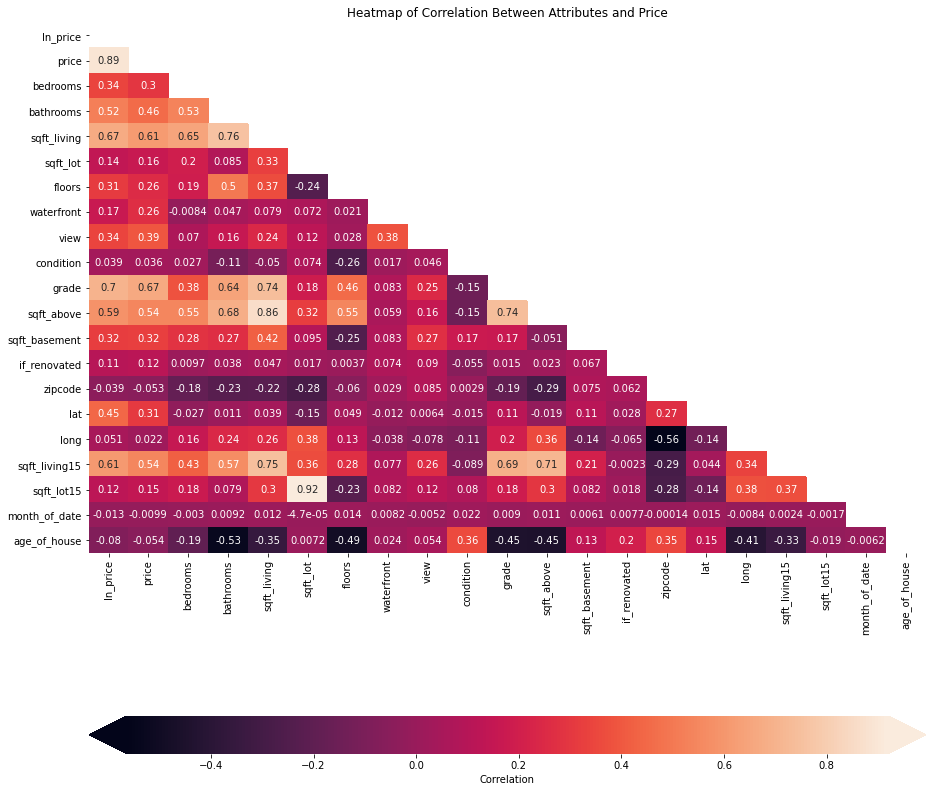

In [140]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['ln_price'], axis=1)
ln_y = df['ln_price']
heatmap_data = pd.concat([ln_y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [31]:
#reporting the correlation between ln price (target) and predictors
df.corr()['ln_price'].drop(['price']).map(abs).sort_values(ascending=False)

ln_price         1.000000
grade            0.703720
sqft_living      0.674802
sqft_living15    0.607154
sqft_above       0.586013
bathrooms        0.520278
lat              0.449133
view             0.344653
bedrooms         0.342850
sqft_basement    0.316920
floors           0.310630
waterfront       0.170720
sqft_lot         0.138261
sqft_lot15       0.123710
if_renovated     0.106528
age_of_house     0.080499
long             0.050862
condition        0.038918
zipcode          0.038788
month_of_date    0.013064
Name: ln_price, dtype: float64

## Data Mainipulation

In [32]:
#create two dataframes, one without ln_price, and without price
output = df.drop(['ln_price'], axis=1) 
output_ln = df.drop(['price'], axis=1) 

In [33]:
def train_test(df, target, test_size=0.20, random_state=42):
    '''
    This function takes in a dataframe df and target column and returns the train and test split
    Default test size is 20, default random state is 42
    '''
    
    df = pd.get_dummies(df, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)
    
    #replace '.' with '_' in column names since sklearn LR has issues with '.'
    df.columns = [x.replace(".","_") for x in df.columns]

    #dropping targets out of predictors
    X = df.drop(target, axis=1)

    #set target with y
    y = df[target]
    
    #creating  train test split for model comparison
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    X_list = [X_train, X_test]
    
    #scaling X values into z-scores
    ss = StandardScaler()
    for i in X_list:
        ss.fit(i)
        i = pd.DataFrame(ss.transform(i))
        i.columns = X.columns
    
    return X_train, X_test, y_train, y_test

## Other Formulas and Useful Objects

In [34]:
def cross_val(estimator,X=X,y=y,n_splits=10,test_size=0.25, random_state=None):
    """
    This formula performs cross validation using shuffled splits. Output is a tuple,
    The 0th element is the median R2 score for the train sets, the 1st element
    is the median R2 score for the test sets.
    
    """
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    output = cross_validate(estimator, X=X, y=y, cv=splitter, return_train_score=True)
    return np.median(output['train_score']), np.median(output['test_score'])

In [35]:
def cval_summary(train,test,diff):
    return f"The median R-squared values for the train sets were {round(train,3)}, the median R-squared values for the test sets were {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

In [36]:
def score_model(model, Xtrain, Xtest, ytrain, ytest, log=False):
    if log == False:
        rmse = mean_squared_error(ytest, model.predict(Xtest), squared=False)
    else:
        rmse = mean_squared_error(np.exp(ytest), np.exp(model.predict(Xtest)), squared=False)
    return model.score(Xtrain, ytrain),  model.score(Xtest, ytest), rmse

In [37]:
def model_summary(train,test,diff,rmse):
    return f"The R-squared value for the train set was {round(train,3)}, and the R-sqaured value for the test set was {round(test,3)}. These values resulted in a differential of {round(diff,5)}. The RMSE of our model predicitons was {round(rmse,2)}"

In [38]:
def normality_test(ols_model):
    residuals = ols_model.resid
    name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
    test = sms.jarque_bera(residuals)
    for name, test in zip(name, test):
        print('\n',name, '----')
        print(test)
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);
    fig.show();

In [39]:
def homoscedasticity_test(ols_model):
    predicted_y = ols_model.predict()
    resids = ols_model.resid

    fig, ax = plt.subplots()

    sns.regplot(x=predicted_y, y=resids, lowess=True, ax=ax, line_kws={'color': 'red'})
    ax.set_title('Residuals vs Fitted', fontsize=16)
    ax.set(xlabel='Fitted Values', ylabel='Residuals')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, ols_model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, ols_model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plot ----')

In [40]:
def predicted_vs_actual(model,X_test,y_test):
    y_predicted = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=y_test, y=y_predicted)
    ax.set_xlabel("Actual Price Values")
    ax.set_ylabel("Predicted Price Values")
    ax.set_title("Actual vs Predicted")
    
    p1 = max(max(y_test), max(y_predicted))
    p2 = min(min(y_test), min(y_predicted))
    plt.plot([p1, p2], [p1, p2], 'b-')

In [41]:
def plot_cooks_distance(c):
    _, ax = plt.subplots(figsize=(9,6))
    ax.stem(c, markerfmt=",")
    ax.set_xlabel("instance")
    ax.set_ylabel("distance")
    ax.set_title("Cook's Distance Outlier Detection")
    return ax

## Baseline Model

### Baseline: Target Price

In [42]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output, 'price')

#create a dummy regressor model based on the target as price
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train,y_train);

In [43]:
#setting up cross validation for price in a different way (x3)
bmodel_cval = cross_val(baseline_model,
                        X=X_train,
                        y=y_train,
                        random_state=0)

bmodel_cval_summary = cval_summary(bmodel_cval[0],
                                   bmodel_cval[1],
                                   abs(bmodel_cval[0]-bmodel_cval[1]))
bmodel_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 0.00016'

In [44]:
baseline_scores = score_model(baseline_model,
                              X_train,
                              X_test,
                              y_train,
                              y_test)

In [45]:
baseline_summary = model_summary(baseline_scores[0],
                                 baseline_scores[1],
                                 abs(baseline_scores[0]-baseline_scores[1]),
                                 baseline_scores[2])
baseline_summary

'The R-squared value for the train set was 0.0, and the R-sqaured value for the test set was -0.0. These values resulted in a differential of 0.00029. The RMSE of our model predicitons was 360906.68'

### Baseline: Target Log-transformed Price

In [46]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

#create `a dummy regressor model based on the target as price
baseline_ln_model = DummyRegressor(strategy='mean')
baseline_ln_model.fit(X_train,y_train);

In [47]:
bmodel_ln_cval = cross_val(baseline_ln_model,
                           X=X_train,
                           y=y_train,
                           random_state=0)

bmodel_ln_cval_summary = cval_summary(bmodel_ln_cval[0],
                                      bmodel_ln_cval[1], 
                                      abs(bmodel_ln_cval[0]-bmodel_ln_cval[1]))
bmodel_ln_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 5e-05'

In [48]:
baseline_ln_scores = score_model(baseline_ln_model,
                                 X_train,
                                 X_test,
                                 y_train,
                                 y_test,
                                 log=True)

baseline_ln_scores

(0.0, -0.00021849595245027054, 367662.96491472365)

In [49]:
baseline_ln_summary = model_summary(baseline_ln_scores[0],
                                    baseline_ln_scores[1],
                                    abs(baseline_ln_scores[0]-baseline_ln_scores[1]),
                                    baseline_ln_scores[2])
baseline_ln_summary

'The R-squared value for the train set was 0.0, and the R-sqaured value for the test set was -0.0. These values resulted in a differential of 0.00022. The RMSE of our model predicitons was 367662.96'

### Summary

After running cross validation with both of our baseline models to ensure data integrity, we found from the results of our regression R-squared scores that the fit of the data we found that the cval, train and test scores were all near 0. This is to be expected of the baseline model due to it's horizontal nature. Exactly 0% of the variation in y train is predicted by a horizontal line through the mean and 100% of it is due to variance.

>The miniscule inscrease in R-squared for the test set is due to the slight change in mean from the train to test sets.

It is also worthwhile to mention that the log-transformed data performed slightly better on the test set than its non-transformed counterpart

## Model 1

Model 1 uses a multiple linear regression model of the data using all parameters, including the dummied out categorical parameters.

### Model 1: Target Price

In [50]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output, 'price')

#create linear regression model for price and setting up cross validation 
model1 = LinearRegression()
model1.fit(X_train, y_train);

In [51]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                        X= X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 0.839, the median R-squared values for the test sets were 0.831. These values resulted in a differential of 0.00835'

In [52]:
model1_scores = score_model(model1,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was 0.838, and the R-sqaured value for the test set was 0.798. These values resulted in a differential of 0.03989. The RMSE of our model predicitons was 162093.89'

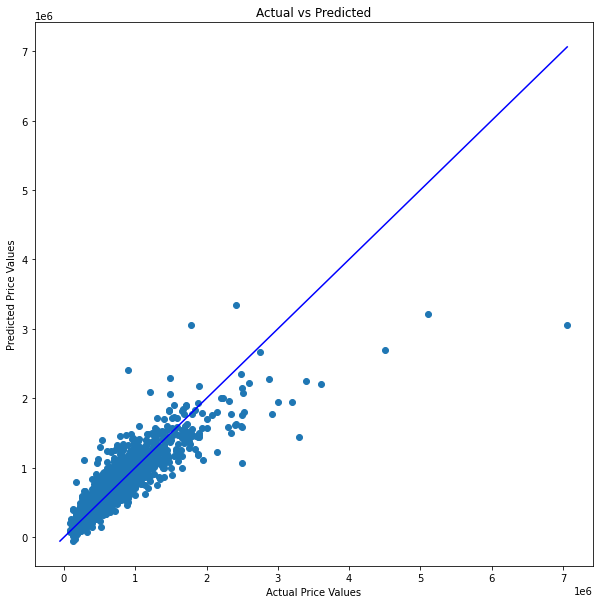

In [53]:
predicted_vs_actual(model1, X_test, y_test)

### Model 1: Target Price - OLS and Assumption Tests

In [54]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model1_ols = sm.OLS(y_train, X_train).fit()

In [55]:
model1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     765.9
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:06:41   Log-Likelihood:            -2.3025e+05
No. Observations:               17277   AIC:                         4.607e+05
Df Residuals:                   17160   BIC:                         4.616e+05
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7.387e+07   1.31e+07     -5.658      0.000   -9.95e+07   -4.83e+07
bedrooms         -1.897e+04   5634.161     -3.367      0.001      -3e+04   -7924.227
bathrooms         3.307e+04   5449.934      6.067      0.000    2.24e+04    4.37e+04
sqft_living      -2.412e+05   1.64e+04    -14.736      0.000   -2.73e+05   -2.09e+05
sqft_lot          3.578e+04   3379.230     10.588      0.000    2.92e+04    4.24e+04
sqft_above        4.578e+05   1.46e+04     31.276      0.000    4.29e+05    4.87e+05
sqft_basement      209.2021      7.668     27.282      0.000     194.172     224.233
lat               1.222e+07   3.13e+06      3.909      0.000    6.09e+06    1.83e+07
long             -2.037e+05   4.69e+04     -4.340      0.000   -2.96e+05   -1.12e+05
sqft_living15     5.416e+04   6262.886      8.649      0.000    4.19e+04    6.64e+04
sqft_lot15       -1.501e+04   3704.643     -4.051      0.000   -2.23e+04   -7747.663
age_of_house       -64.2315     74.510     -0.862      0.389    -210.280      81.817
floors_1_5       -1.598e+04   4721.933     -3.383      0.001   -2.52e+04   -6719.713
floors_2_0       -1.176e+04   4060.668     -2.895      0.004   -1.97e+04   -3798.309
floors_2_5        7.201e+04   1.41e+04      5.109      0.000    4.44e+04    9.96e+04
floors_3_0       -6.432e+04   8802.717     -7.306      0.000   -8.16e+04   -4.71e+04
floors_3_5        1.463e+04   5.68e+04      0.258      0.797   -9.67e+04    1.26e+05
waterfront_1      5.881e+05   1.71e+04     34.458      0.000    5.55e+05    6.22e+05
view_1            9.176e+04   9633.943      9.525      0.000    7.29e+04    1.11e+05
view_2            5.688e+04   5859.335      9.708      0.000    4.54e+04    6.84e+04
view_3            1.443e+05   8042.511     17.948      0.000    1.29e+05     1.6e+05
view_4            2.811e+05   1.18e+04     23.873      0.000    2.58e+05    3.04e+05
condition_2       7.566e+04   3.68e+04      2.057      0.040    3565.327    1.48e+05
condition_3       8.735e+04   3.47e+04      2.519      0.012    1.94e+04    1.55e+05
condition_4       1.133e+05   3.47e+04      3.266      0.001    4.53e+04    1.81e+05
condition_5       1.676e+05   3.49e+04      4.807      0.000    9.92e+04    2.36e+05
grade_4          -1.555e+05   1.53e+05     -1.013      0.311   -4.56e+05    1.45e+05
grade_5          -1.857e+05    1.5e+05     -1.238      0.216    -4.8e+05    1.08e+05
grade_6           -2.09e+05    1.5e+05     -1.397      0.163   -5.02e+05    8.43e+04
grade_7          -2.167e+05    1.5e+05     -1.448      0.148    -5.1e+05    7.66e+04
grade_8          -1.974e+05    1.5e+05     -1.318      0.187   -4.91e+05    9.61e+04
grade_9          -1.023e+05    1.5e+05     -0.683      0.495   -3.96e+05    1.91e+05
grade_10          5.305e+04    1.5e+05      0.354      0.723   -2.41e+05    3.47e+05
grade_11          3.025


 Jarque-Bera ----
1099434.4812572733

 Prob ----
0.0

 Skew ----
2.7566982479425097

 Kurtosis ----
41.68927426338533


<ipython-input-38-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


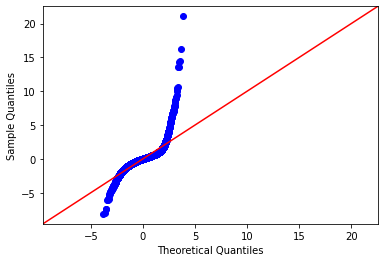

In [56]:
#test for normality
normality_test(model1_ols);


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  4516.983395
p-value                           0.000000
f-value                          52.366862
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  0.860172
p-value      1.000000

 Residuals plot ----


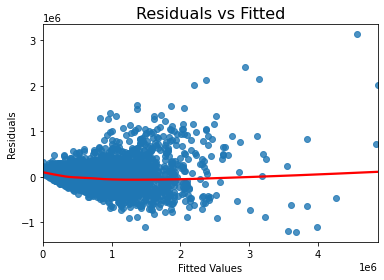

In [57]:
#test for homoscedasticity
homoscedasticity_test(model1_ols)

### Model 1: Target Price - Influence and Outliers

In [58]:
#find the cooks distance
inf = influence(model1_ols)
C, P = inf.cooks_distance

/Users/arthur/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/Users/arthur/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance', ylabel='distance'>

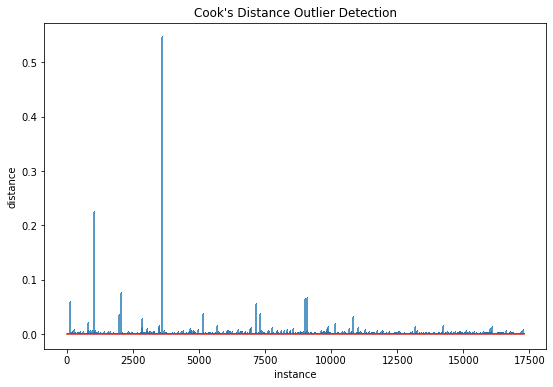

In [59]:
#plot cooks distance
plot_cooks_distance(C)

In [60]:
#create a new dataframe from main dataframe
train_df = pd.concat([y_train, X_train], axis=1)

#add new column for cooks distance
train_df['influence'] = C

In [61]:
#using the IQR rule, check what proportion of influence are outliers
quantile_75 = train_df['influence'].quantile(0.75)
quantile_25 = train_df['influence'].quantile(0.25)
iqr = quantile_75-quantile_25

elim_train_df = train_df[(train_df['influence'] > quantile_75 + 3*iqr) | 
                       (train_df['influence'] < quantile_25 - 3*iqr)]

percent = len(elim_train_df)/len(train_df)

In [62]:
#sort the dataframe by cooks distance and instantiate to new dataframe
train_df.sort_values(by='influence', ascending=False, inplace=True)

#number of rows to remove
x = round(percent*len(train_df))

#find the indexes related to the top x rows by cooks distance
list_index = list(train_df.head(x).index)

In [63]:
#drop any rows with the index of top x rows by cooks distance and any nulls
train_df.drop(index=list_index, inplace=True)
train_df.drop(columns=['influence','const'], inplace=True)

### Model 1: Target Price - Retesting Based on Removed Outliers

In [64]:
#split data into train and test
X_train = train_df.drop(['price'], axis = 1)
y_train = train_df['price']

In [65]:
#create linear regression model for price and setting up cross validation 
model1_adj = LinearRegression()
model1_adj.fit(X_train, y_train);

In [66]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1_adj,
                        X=X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 0.908, the median R-squared values for the test sets were 0.904. These values resulted in a differential of 0.00353'

In [67]:
model1_scores = score_model(model1_adj,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was 0.907, and the R-sqaured value for the test set was 0.792. These values resulted in a differential of 0.11568. The RMSE of our model predicitons was 164738.16'

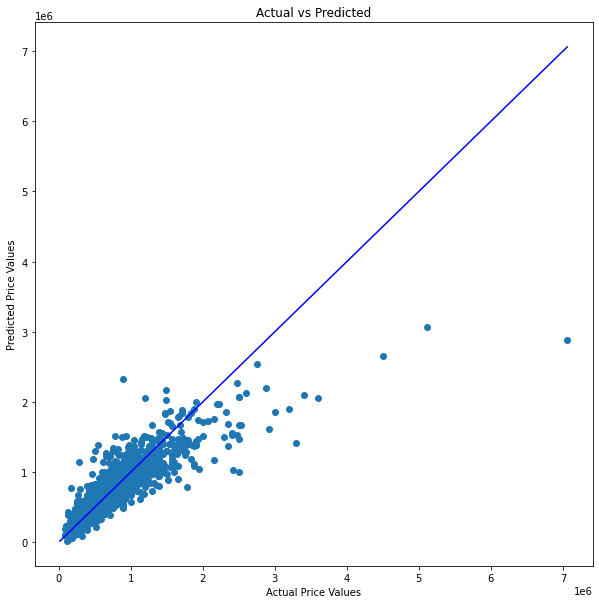

In [68]:
predicted_vs_actual(model1_adj, X_test, y_test)

In [69]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model1_adj_ols = sm.OLS(y_train, X_train).fit()

In [70]:
model1_adj_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     1321.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:07:16   Log-Likelihood:            -1.9750e+05
No. Observations:               15644   AIC:                         3.952e+05
Df Residuals:                   15528   BIC:                         3.961e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4.221e+07    6.9e+06     -6.120      0.000   -5.57e+07   -2.87e+07
bedrooms         -1.029e+04   2991.551     -3.439      0.001   -1.62e+04   -4423.494
bathrooms         1.868e+04   2857.671      6.538      0.000    1.31e+04    2.43e+04
sqft_living       -1.11e+05   9766.624    -11.369      0.000    -1.3e+05   -9.19e+04
sqft_lot          2.983e+04   1855.985     16.072      0.000    2.62e+04    3.35e+04
sqft_above        2.913e+05   8821.273     33.021      0.000    2.74e+05    3.09e+05
sqft_basement      140.9046      4.974     28.329      0.000     131.155     150.654
lat               6.268e+06   1.64e+06      3.819      0.000    3.05e+06    9.49e+06
long             -1.349e+05   2.56e+04     -5.274      0.000   -1.85e+05   -8.48e+04
sqft_living15     4.855e+04   3332.950     14.567      0.000     4.2e+04    5.51e+04
sqft_lot15       -9657.1502   2004.190     -4.818      0.000   -1.36e+04   -5728.704
age_of_house       -42.5767     40.506     -1.051      0.293    -121.973      36.820
floors_1_5       -2959.0695   2500.544     -1.183      0.237   -7860.427    1942.288
floors_2_0       -1043.5031   2153.706     -0.485      0.628   -5265.019    3178.012
floors_2_5        6.549e+04   1.04e+04      6.327      0.000    4.52e+04    8.58e+04
floors_3_0       -5.015e+04   4712.050    -10.642      0.000   -5.94e+04   -4.09e+04
floors_3_5        1.331e+04   4.29e+04      0.311      0.756   -7.07e+04    9.73e+04
waterfront_1      5.991e+05   2.01e+04     29.835      0.000     5.6e+05    6.38e+05
view_1             7.91e+04   5823.174     13.584      0.000    6.77e+04    9.05e+04
view_2             5.85e+04   3267.845     17.901      0.000    5.21e+04    6.49e+04
view_3            1.373e+05   5075.529     27.056      0.000    1.27e+05    1.47e+05
view_4            2.715e+05   9365.142     28.994      0.000    2.53e+05     2.9e+05
condition_2       5.619e+04   3.12e+04      1.799      0.072   -5038.397    1.17e+05
condition_3       8.011e+04   3.04e+04      2.631      0.009    2.04e+04     1.4e+05
condition_4       1.003e+05   3.05e+04      3.293      0.001    4.06e+04     1.6e+05
condition_5       1.444e+05   3.05e+04      4.732      0.000    8.46e+04    2.04e+05
grade_4          -1.341e+05   7.87e+04     -1.704      0.088   -2.88e+05    2.01e+04
grade_5          -1.779e+05   7.44e+04     -2.391      0.017   -3.24e+05   -3.21e+04
grade_6          -1.884e+05   7.42e+04     -2.540      0.011   -3.34e+05    -4.3e+04
grade_7          -1.831e+05   7.42e+04     -2.467      0.014   -3.29e+05   -3.76e+04
grade_8          -1.538e+05   7.43e+04     -2.072      0.038   -2.99e+05   -8277.885
grade_9          -5.913e+04   7.43e+04     -0.796      0.426   -2.05e+05    8.65e+04
grade_10          6.801e+04   7.44e+04      0.914      0.361   -7.78e+04    2.14e+05
grade_11          3.626


 Jarque-Bera ----
413.2995746797828

 Prob ----
1.7911735679408028e-90

 Skew ----
0.25487836544450754

 Kurtosis ----
3.6117231469770275


<ipython-input-38-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


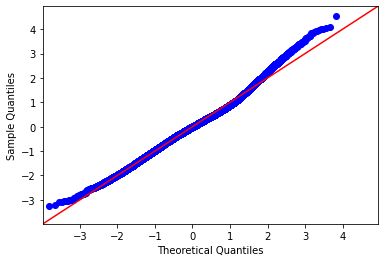

In [71]:
#test for normality
normality_test(model1_adj_ols);


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  2654.340286
p-value                           0.000000
f-value                          27.591576
f p-value                         0.000000

 Goldfeld-Quandt test ----
               value
F statistic  0.07958
p-value      1.00000

 Residuals plot ----


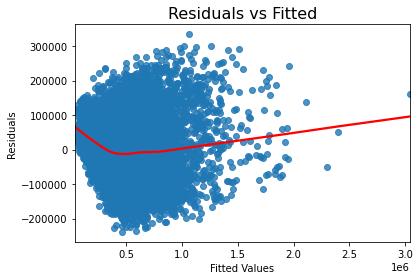

In [72]:
#test for homoscedasticity
homoscedasticity_test(model1_adj_ols)

### Model 1: Target Log-transformed Price

In [73]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

#create linear regression model for ln price
model1_ln= LinearRegression()
model1_ln.fit(X_train, y_train);

In [74]:
#setting up cross validation
model1_ln_cval = cross_val(model1_ln,
                           X=X_train,
                           y=y_train,
                           random_state=0)

model1_ln_cval_summary = cval_summary(model1_ln_cval[0],
                                      model1_ln_cval[1],
                                      abs(model1_ln_cval[0]-model1_ln_cval[1]))
model1_ln_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.886. These values resulted in a differential of 0.00218'

In [75]:
#find the test score using the linear model
model1_ln_scores = score_model(model1_ln,
                             X_train,
                             X_test,
                             y_train,
                             y_test,
                             log=True)

model1_ln_summary = model_summary(model1_ln_scores[0],
                                  model1_ln_scores[1],
                                  abs(model1_ln_scores[0]-model1_ln_scores[1]),
                                  model1_ln_scores[2])
model1_ln_summary

'The R-squared value for the train set was 0.888, and the R-sqaured value for the test set was 0.885. These values resulted in a differential of 0.00362. The RMSE of our model predicitons was 122833.42'

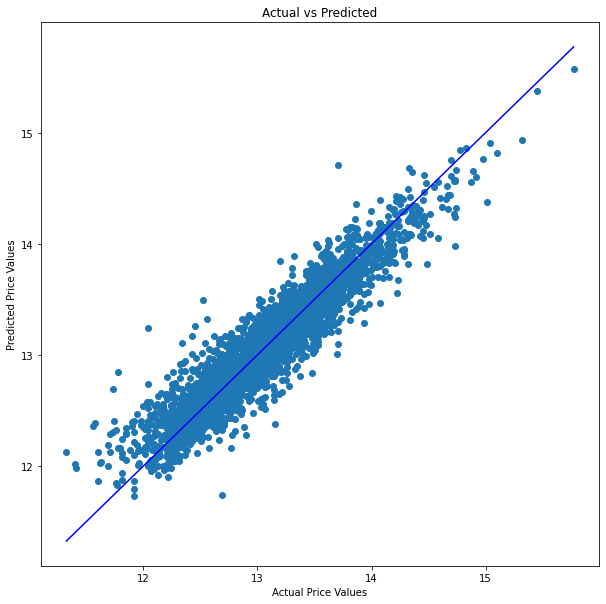

In [76]:
predicted_vs_actual(model1_ln, X_test, y_test)

### Model 1: Log-transformed Price - OLS and Assumption Tests

In [77]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model1_ln_ols = sm.OLS(y_train, X_train).fit()

In [78]:
model1_ln_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1175.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:07:48   Log-Likelihood:                 5457.7
No. Observations:               17277   AIC:                        -1.068e+04
Df Residuals:                   17160   BIC:                            -9774.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -146.9238     15.517     -9.468      0.000    -177.339    -116.508
bedrooms            -0.0473      0.007     -7.065      0.000      -0.060      -0.034
bathrooms            0.0574      0.006      8.861      0.000       0.045       0.070
sqft_living          0.2774      0.019     14.260      0.000       0.239       0.316
sqft_lot             0.0742      0.004     18.479      0.000       0.066       0.082
sqft_above           0.1551      0.017      8.916      0.000       0.121       0.189
sqft_basement     1.058e-05   9.11e-06      1.161      0.246   -7.28e-06    2.84e-05
lat                 25.8726      3.716      6.963      0.000      18.589      33.156
long                -0.4488      0.056     -8.044      0.000      -0.558      -0.339
sqft_living15        0.1561      0.007     20.974      0.000       0.142       0.171
sqft_lot15          -0.0222      0.004     -5.039      0.000      -0.031      -0.014
age_of_house     -8.445e-06   8.86e-05     -0.095      0.924      -0.000       0.000
floors_1_5           0.0053      0.006      0.941      0.347      -0.006       0.016
floors_2_0          -0.0082      0.005     -1.692      0.091      -0.018       0.001
floors_2_5           0.0040      0.017      0.237      0.813      -0.029       0.037
floors_3_0          -0.0809      0.010     -7.729      0.000      -0.101      -0.060
floors_3_5          -0.0686      0.067     -1.017      0.309      -0.201       0.064
waterfront_1         0.4597      0.020     22.666      0.000       0.420       0.500
view_1               0.1229      0.011     10.736      0.000       0.100       0.145
view_2               0.0986      0.007     14.162      0.000       0.085       0.112
view_3               0.1735      0.010     18.152      0.000       0.155       0.192
view_4               0.2841      0.014     20.298      0.000       0.257       0.311
condition_2          0.1455      0.044      3.329      0.001       0.060       0.231
condition_3          0.2603      0.041      6.316      0.000       0.179       0.341
condition_4          0.3029      0.041      7.347      0.000       0.222       0.384
condition_5          0.3719      0.041      8.976      0.000       0.291       0.453
grade_4             -0.6112      0.182     -3.352      0.001      -0.969      -0.254
grade_5             -0.5339      0.178     -2.996      0.003      -0.883      -0.185
grade_6             -0.4858      0.178     -2.732      0.006      -0.834      -0.137
grade_7             -0.4167      0.178     -2.343      0.019      -0.765      -0.068
grade_8             -0.3372      0.178     -1.895      0.058      -0.686       0.012
grade_9             -0.2207      0.178     -1.239      0.215      -0.570       0.128
grade_10            -0.1295      0.178     -0.727      0.467      -0.479       0.220
grade_11            -0.


 Jarque-Bera ----
5395.9703804465325

 Prob ----
0.0

 Skew ----
-0.212947932614161

 Kurtosis ----
5.704499464923025


<ipython-input-38-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


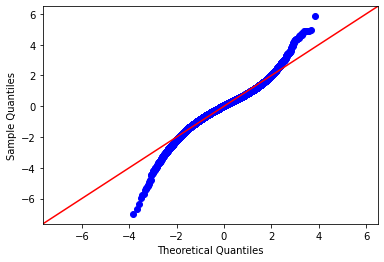

In [79]:
#test for normality
normality_test(model1_ln_ols);


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.656417e+03
p-value                        1.176872e-270
f-value                         1.568671e+01
f p-value                      1.298747e-286

 Goldfeld-Quandt test ----
                value
F statistic  0.971864
p-value      0.906125

 Residuals plot ----


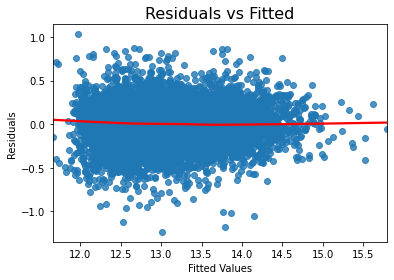

In [80]:
#test for homoscedasticity
homoscedasticity_test(model1_ln_ols)

### Model 1: Log-transformed Price  - Influence and Outliers

In [81]:
#find the cooks distance
inf = influence(model1_ln_ols)
C, P = inf.cooks_distance

/Users/arthur/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/Users/arthur/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance', ylabel='distance'>

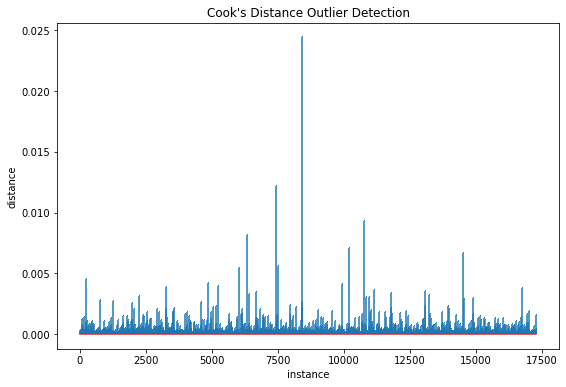

In [82]:
#plot cooks distance
plot_cooks_distance(C)

In [83]:
#create a new dataframe from main dataframe
train_df = pd.concat([y_train, X_train], axis=1)

#add new column for cooks distance
train_df['influence'] = C

In [84]:
#using the IQR rule, check what proportion of influence are outliers
quantile_75 = train_df['influence'].quantile(0.75)
quantile_25 = train_df['influence'].quantile(0.25)
iqr = quantile_75-quantile_25

elim_train_df = train_df[(train_df['influence'] > quantile_75 + 3*iqr) | 
                       (train_df['influence'] < quantile_25 - 3*iqr)]


In [85]:
#sort the dataframe by cooks distance and instantiate to new dataframe
train_df.sort_values(by='influence', ascending=False, inplace=True)

#find the indexes related to the top x rows by cooks distance
list_index = list(elim_train_df.index)

In [86]:
#drop any rows with the index of top x rows by cooks distance and any nulls
train_df.drop(index=list_index, inplace=True)
train_df.drop(columns=['influence','const'], inplace=True)

### Model 1: Log-transformed Price  - Retesting Based on Removed Outliers

In [87]:
#split data into train and test
X_train = train_df.drop(['ln_price'], axis = 1)
y_train = train_df['ln_price']

#create linear regression model for ln price
model1_ln_adj= LinearRegression()
model1_ln_adj.fit(X_train, y_train);

In [88]:
#setting up cross validation
model1_ln_cval = cross_val(model1_ln_adj,
                           X=X_train,
                           y=y_train,
                           random_state=0)

model1_ln_cval_summary = cval_summary(model1_ln_cval[0],
                                      model1_ln_cval[1],
                                      abs(model1_ln_cval[0]-model1_ln_cval[1]))
model1_ln_cval_summary

'The median R-squared values for the train sets were 0.925, the median R-squared values for the test sets were 0.923. These values resulted in a differential of 0.00132'

In [89]:
#find the test score using the linear model
model1_ln_scores = score_model(model1_ln_adj,
                             X_train,
                             X_test,
                             y_train,
                             y_test,
                             log=True)

model1_ln_summary = model_summary(model1_ln_scores[0],
                                  model1_ln_scores[1],
                                  abs(model1_ln_scores[0]-model1_ln_scores[1]),
                                  model1_ln_scores[2])
model1_ln_summary

'The R-squared value for the train set was 0.925, and the R-sqaured value for the test set was 0.884. These values resulted in a differential of 0.04003. The RMSE of our model predicitons was 123300.25'

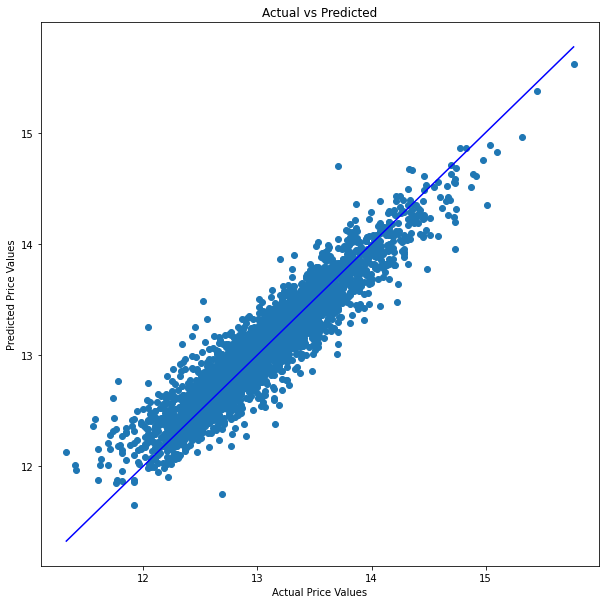

In [90]:
predicted_vs_actual(model1_ln_adj, X_test, y_test)

In [91]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model1_ln_adj_ols = sm.OLS(y_train, X_train).fit()

In [92]:
model1_ln_adj_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1698.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:08:26   Log-Likelihood:                 9434.1
No. Observations:               16063   AIC:                        -1.864e+04
Df Residuals:                   15947   BIC:                        -1.774e+04
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -115.1949     12.631     -9.120      0.000    -139.952     -90.437
bedrooms            -0.0375      0.005     -6.885      0.000      -0.048      -0.027
bathrooms            0.0518      0.005      9.970      0.000       0.042       0.062
sqft_living          0.2605      0.016     15.998      0.000       0.229       0.292
sqft_lot             0.0681      0.003     20.116      0.000       0.061       0.075
sqft_above           0.1703      0.015     11.691      0.000       0.142       0.199
sqft_basement     1.545e-05   7.81e-06      1.979      0.048    1.48e-07    3.08e-05
lat                 22.3270      2.990      7.466      0.000      16.465      28.189
long                -0.3010      0.053     -5.727      0.000      -0.404      -0.198
sqft_living15        0.1499      0.006     24.895      0.000       0.138       0.162
sqft_lot15          -0.0183      0.004     -4.987      0.000      -0.025      -0.011
age_of_house        -0.0001    7.2e-05     -1.546      0.122      -0.000    2.98e-05
floors_1_5           0.0065      0.005      1.441      0.150      -0.002       0.015
floors_2_0          -0.0107      0.004     -2.774      0.006      -0.018      -0.003
floors_2_5          -0.0099      0.015     -0.663      0.507      -0.039       0.019
floors_3_0          -0.0962      0.008    -11.552      0.000      -0.113      -0.080
floors_3_5        4.426e-14   5.62e-15      7.870      0.000    3.32e-14    5.53e-14
waterfront_1         0.5015      0.020     25.700      0.000       0.463       0.540
view_1               0.1030      0.010     10.765      0.000       0.084       0.122
view_2               0.0937      0.006     16.599      0.000       0.083       0.105
view_3               0.1687      0.008     20.768      0.000       0.153       0.185
view_4               0.2668      0.012     21.643      0.000       0.243       0.291
condition_2          0.2288      0.136      1.678      0.093      -0.038       0.496
condition_3          0.3590      0.135      2.652      0.008       0.094       0.624
condition_4          0.3946      0.135      2.915      0.004       0.129       0.660
condition_5          0.4686      0.135      3.461      0.001       0.203       0.734
grade_4             -0.6081      0.148     -4.096      0.000      -0.899      -0.317
grade_5             -0.5647      0.136     -4.147      0.000      -0.832      -0.298
grade_6             -0.4894      0.136     -3.608      0.000      -0.755      -0.224
grade_7             -0.4278      0.136     -3.153      0.002      -0.694      -0.162
grade_8             -0.3544      0.136     -2.610      0.009      -0.620      -0.088
grade_9             -0.2370      0.136     -1.745      0.081      -0.503       0.029
grade_10            -0.1541      0.136     -1.134      0.257      -0.421       0.112
grade_11            -0.


 Jarque-Bera ----
39.21065628832413

 Prob ----
3.058540045459149e-09

 Skew ----
-0.12097090822413592

 Kurtosis ----
2.9929670597494935


<ipython-input-38-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


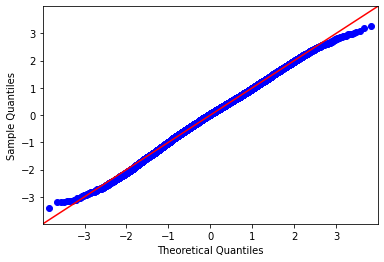

In [93]:
#test for normality
normality_test(model1_ln_adj_ols);


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.371707e+03
p-value                        1.708461e-213
f-value                         1.294740e+01
f p-value                      2.275047e-225

 Goldfeld-Quandt test ----
                value
F statistic  0.079019
p-value      1.000000

 Residuals plot ----


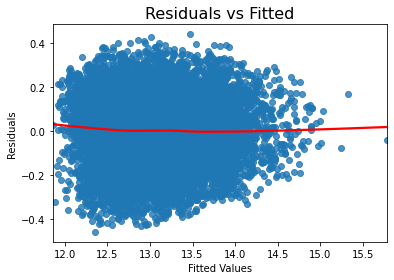

In [94]:
#test for homoscedasticity
homoscedasticity_test(model1_ln_adj_ols)

### Summary

## Model 2

In Model 2 we drop features that had a relatively high p-value (alpha = 0.05) from Model 1 ln price OLS without outliers removed to look for improvement in model fit.

### Model 2: Filtering by p-value

In [95]:
#create a dataframe for the parameters and pvalues
results = pd.DataFrame(model1_ln_ols.pvalues)
results.reset_index(inplace=True)

#rename the columns
results.rename(columns={'index': 'parameter', 0: 'pvalue'}, inplace=True)

#create a list of parameters that have a pvalue < 0.05
params = results[results['pvalue'] < 0.05]
parameters = list(params['parameter'])

#the intercept constant is not needed 
parameters.remove('const')

### Model 2: Fitting and Validation

In [96]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

#create linear regression model for price and setting up cross validation (x3)
model2 = LinearRegression()
model2.fit(X_train[parameters], y_train);

In [97]:
#setting up cross validation
model2_cval = cross_val(model2,
                        X=X_train[parameters],
                        y=y_train,
                        random_state=0)

model2_cval_summary = cval_summary(model2_cval[0],
                                   model2_cval[1],
                                   abs(model2_cval[0]-model2_cval[1]))
model2_cval_summary

'The median R-squared values for the train sets were 0.878, the median R-squared values for the test sets were 0.876. These values resulted in a differential of 0.00214'

In [98]:
#find the test score using the linear model
model2_scores = score_model(model2,
                             X_train[parameters],
                             X_test[parameters],
                             y_train,
                             y_test,
                             log=True)

model2_summary = model_summary(model2_scores[0],
                               model2_scores[1],
                               abs(model2_scores[0]-model2_scores[1]),
                               model2_scores[2])
model2_summary

'The R-squared value for the train set was 0.878, and the R-sqaured value for the test set was 0.873. These values resulted in a differential of 0.00523. The RMSE of our model predicitons was 139179.26'

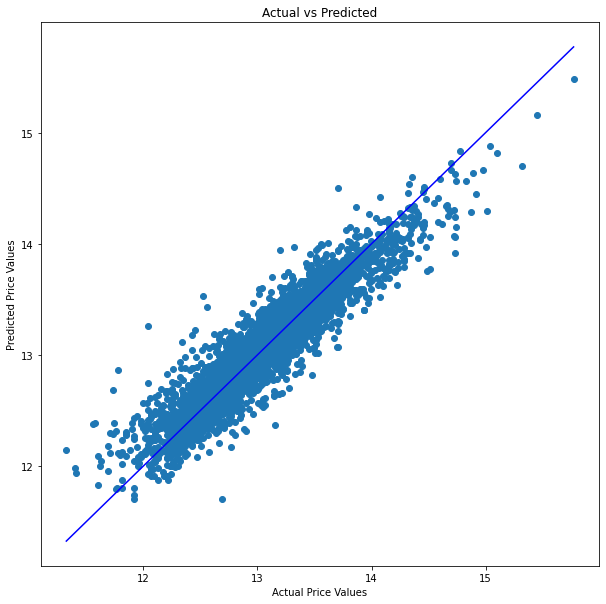

In [99]:
predicted_vs_actual(model2, X_test[parameters], y_test)

### Model 2: OLS and Assumption Tests

In [100]:
#add constant to X_train
X_train = sm.add_constant(X_train[parameters])

#find OLS for train data set
model2_ols = sm.OLS(y_train, X_train).fit()

In [101]:
model2_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     1329.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:08:58   Log-Likelihood:                 4697.2
No. Observations:               17277   AIC:                            -9206.
Df Residuals:                   17183   BIC:                            -8477.
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -144.0969     11.680    -12.338      0.000    -166.990    -121.204
bedrooms           -0.0834      0.007    -12.151      0.000      -0.097      -0.070
bathrooms           0.0597      0.006      9.606      0.000       0.048       0.072
sqft_living         0.3327      0.009     35.730      0.000       0.314       0.351
sqft_lot            0.0778      0.004     19.003      0.000       0.070       0.086
sqft_above          0.1992      0.007     26.701      0.000       0.185       0.214
lat                25.8524      2.774      9.320      0.000      20.415      31.289
long               -0.4148      0.055     -7.493      0.000      -0.523      -0.306
sqft_living15       0.1930      0.008     25.188      0.000       0.178       0.208
sqft_lot15         -0.0162      0.005     -3.526      0.000      -0.025      -0.007
floors_3_0         -0.0622      0.009     -6.570      0.000      -0.081      -0.044
waterfront_1        0.4598      0.021     21.753      0.000       0.418       0.501
view_1              0.1273      0.012     10.696      0.000       0.104       0.151
view_2              0.1133      0.007     15.714      0.000       0.099       0.127
view_3              0.2018      0.010     20.454      0.000       0.182       0.221
view_4              0.3392      0.014     23.519      0.000       0.311       0.368
condition_2         0.1662      0.046      3.643      0.000       0.077       0.256
condition_3         0.2854      0.043      6.638      0.000       0.201       0.370
condition_4         0.3191      0.043      7.415      0.000       0.235       0.403
condition_5         0.3869      0.043      8.949      0.000       0.302       0.472
grade_4            -0.2078      0.043     -4.811      0.000      -0.292      -0.123
grade_5            -0.1507      0.015    -10.292      0.000      -0.179      -0.122
grade_6            -0.1170      0.007    -17.171      0.000      -0.130      -0.104
grade_7            -0.0805      0.004    -20.108      0.000      -0.088      -0.073
grade_13            0.5151      0.057      9.106      0.000       0.404       0.626
if_renovated_1      0.0594      0.008      7.501      0.000       0.044       0.075
zipcode_98004       1.0178      0.021     48.385      0.000       0.977       1.059
zipcode_98005       0.6343      0.024     26.242      0.000       0.587       0.682
zipcode_98006       0.5964      0.019     31.550      0.000       0.559       0.633
zipcode_98007       0.5647      0.026     21.974      0.000       0.514       0.615
zipcode_98008       0.5589      0.023     24.087      0.000       0.513       0.604
zipcode_98010       0.3181      0.026     12.145      0.000       0.267       0.369
zipcode_98011       0.2267      0.029      7.785      0.000       0.170       0.284
zipcode_98014       0.2544      0.038      6.745      0.000


 Jarque-Bera ----
4056.2719226231247

 Prob ----
0.0

 Skew ----
-0.11071828459090968

 Kurtosis ----
5.363399055202777


<ipython-input-38-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


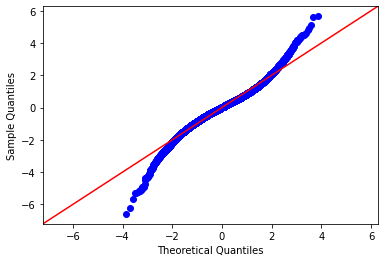

In [102]:
#test for normality
normality_test(model2_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.604179e+03
p-value                        8.247906e-274
f-value                         1.891132e+01
f p-value                      3.984970e-289

 Goldfeld-Quandt test ----
                value
F statistic  0.975443
p-value      0.874746

 Residuals plot ----


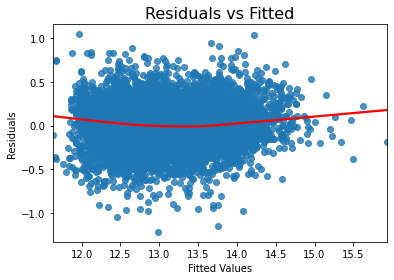

In [103]:
#test for homoscedasticity
homoscedasticity_test(model2_ols)

### Summary

Our fit on the data has dropped drastically by removing features containing p-values greater than 0.05. In light of this signifigant decrease in accuracy we will still be relying on our "best model", which is currently model 1.

## Model 3

Model 3 uses the same dataframe structure as Model 1, but introduces recursive feature elimination (RFE) of varying n_parameters  to improve on the model.

### Model 3: Recursive Feature Elimination (RFE)

In [104]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

In [105]:
#determine how many features we have
len(X_train.columns)

116

In [106]:
#determine n for REF
n = [10, 20, 50, 100]

key_cols = {}

for x in n:
    #instatiate Linear Regression
    lr_rfe = LinearRegression()
    select = RFE(lr_rfe, n_features_to_select=x)
    
    #fit model to RFE
    select.fit(X=X_train, y=y_train)
    
    #obtain the indexes where select.support_ is true
    true_indexes = [i for i, x in enumerate(select.support_) if x]
    
    #create a list of all column names matched with index and add to dictionary
    key_columns = []
    for i in true_indexes:
        key_columns.append(X_train.columns[i])
    key_cols["key_cols_{0}".format(x)] = key_columns 

### Model 3: Testing 10 Features

In [107]:
#create linear regression model for price and setting up cross validation (x3)
model3_10 = LinearRegression()
model3_10.fit(X_train[key_cols['key_cols_10']], y_train);

In [108]:
#setting up cross validation for price in a different way (x3)
model3_10_cval = cross_val(model3_10,
                       X=X_train[key_cols['key_cols_10']],
                       y=y_train,
                       random_state=0,)

model3_10_cval_summary = cval_summary(model3_10_cval[0],
                                      model3_10_cval[1],
                                      abs(model3_10_cval[0]-model3_10_cval[1]))

model3_10_cval_summary

'The median R-squared values for the train sets were 0.712, the median R-squared values for the test sets were 0.712. These values resulted in a differential of 0.0003'

In [109]:
#find the test score using the linear model
model3_10_scores = score_model(model3_10,
                           X_train[key_cols['key_cols_10']],
                           X_test[key_cols['key_cols_10']],
                           y_train,
                           y_test,
                              log=True)

model3_10_summary = model_summary(model3_10_scores[0],
                                  model3_10_scores[1],
                                  abs(model3_10_scores[0]-model3_10_scores[1]),
                                  model3_10_scores[2])
model3_10_summary

'The R-squared value for the train set was 0.712, and the R-sqaured value for the test set was 0.707. These values resulted in a differential of 0.00509. The RMSE of our model predicitons was 192974.66'

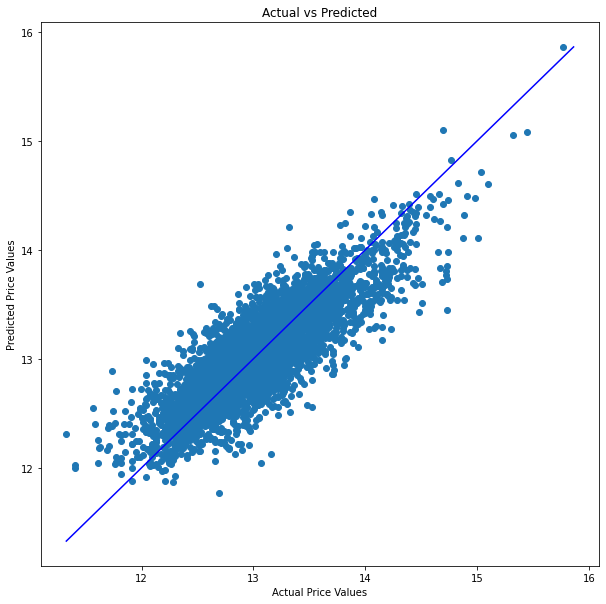

In [110]:
predicted_vs_actual(model3_10, X_test[key_cols['key_cols_10']], y_test)

In [111]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model3_10_ols = sm.OLS(y_train, X_train).fit()

In [112]:
model3_10_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1175.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:10:08   Log-Likelihood:                 5457.7
No. Observations:               17277   AIC:                        -1.068e+04
Df Residuals:                   17160   BIC:                            -9774.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -146.9238     15.517     -9.468      0.000    -177.339    -116.508
bedrooms            -0.0473      0.007     -7.065      0.000      -0.060      -0.034
bathrooms            0.0574      0.006      8.861      0.000       0.045       0.070
sqft_living          0.2774      0.019     14.260      0.000       0.239       0.316
sqft_lot             0.0742      0.004     18.479      0.000       0.066       0.082
sqft_above           0.1551      0.017      8.916      0.000       0.121       0.189
sqft_basement     1.058e-05   9.11e-06      1.161      0.246   -7.28e-06    2.84e-05
lat                 25.8726      3.716      6.963      0.000      18.589      33.156
long                -0.4488      0.056     -8.044      0.000      -0.558      -0.339
sqft_living15        0.1561      0.007     20.974      0.000       0.142       0.171
sqft_lot15          -0.0222      0.004     -5.039      0.000      -0.031      -0.014
age_of_house     -8.445e-06   8.86e-05     -0.095      0.924      -0.000       0.000
floors_1_5           0.0053      0.006      0.941      0.347      -0.006       0.016
floors_2_0          -0.0082      0.005     -1.692      0.091      -0.018       0.001
floors_2_5           0.0040      0.017      0.237      0.813      -0.029       0.037
floors_3_0          -0.0809      0.010     -7.729      0.000      -0.101      -0.060
floors_3_5          -0.0686      0.067     -1.017      0.309      -0.201       0.064
waterfront_1         0.4597      0.020     22.666      0.000       0.420       0.500
view_1               0.1229      0.011     10.736      0.000       0.100       0.145
view_2               0.0986      0.007     14.162      0.000       0.085       0.112
view_3               0.1735      0.010     18.152      0.000       0.155       0.192
view_4               0.2841      0.014     20.298      0.000       0.257       0.311
condition_2          0.1455      0.044      3.329      0.001       0.060       0.231
condition_3          0.2603      0.041      6.316      0.000       0.179       0.341
condition_4          0.3029      0.041      7.347      0.000       0.222       0.384
condition_5          0.3719      0.041      8.976      0.000       0.291       0.453
grade_4             -0.6112      0.182     -3.352      0.001      -0.969      -0.254
grade_5             -0.5339      0.178     -2.996      0.003      -0.883      -0.185
grade_6             -0.4858      0.178     -2.732      0.006      -0.834      -0.137
grade_7             -0.4167      0.178     -2.343      0.019      -0.765      -0.068
grade_8             -0.3372      0.178     -1.895      0.058      -0.686       0.012
grade_9             -0.2207      0.178     -1.239      0.215      -0.570       0.128
grade_10            -0.1295      0.178     -0.727      0.467      -0.479       0.220
grade_11            -0.


 Jarque-Bera ----
5395.9703804465325

 Prob ----
0.0

 Skew ----
-0.212947932614161

 Kurtosis ----
5.704499464923025


<ipython-input-38-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


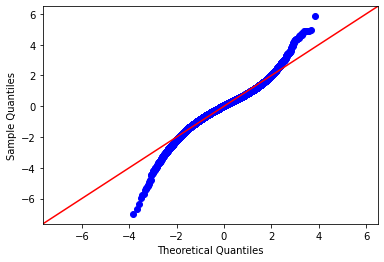

In [113]:
#test for normality
normality_test(model3_10_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.656417e+03
p-value                        1.176872e-270
f-value                         1.568671e+01
f p-value                      1.298747e-286

 Goldfeld-Quandt test ----
                value
F statistic  0.971864
p-value      0.906125

 Residuals plot ----


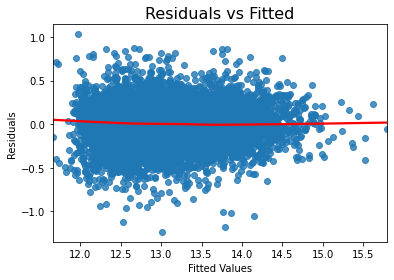

In [114]:
#test for homoscedasticity
homoscedasticity_test(model3_10_ols)

### Model 3: Testing 20 Features

In [115]:
#create linear regression model for price and setting up cross validation (x3)
model3_20 = LinearRegression()
model3_20.fit(X_train[key_cols['key_cols_20']], y_train);

In [116]:
#setting up cross validation for price in a different way (x3)
model3_20_cval = cross_val(model3_20,
                           X=X_train[key_cols['key_cols_20']],
                           y=y_train,
                           random_state=0,)

model3_20_cval_summary = cval_summary(model3_20_cval[0],
                                      model3_20_cval[1],
                                      abs(model3_20_cval[0]-model3_20_cval[1]))

model3_20_cval_summary

'The median R-squared values for the train sets were 0.773, the median R-squared values for the test sets were 0.772. These values resulted in a differential of 0.0008'

In [117]:
#find the test score using the linear model
model3_20_scores = score_model(model3_20,
                               X_train[key_cols['key_cols_20']],
                               X_test[key_cols['key_cols_20']],
                               y_train,
                               y_test,
                               log=True)

model3_20_summary = model_summary(model3_20_scores[0],
                                  model3_20_scores[1],
                                  abs(model3_20_scores[0]-model3_20_scores[1]),
                                  model3_20_scores[2])
model3_20_summary

'The R-squared value for the train set was 0.773, and the R-sqaured value for the test set was 0.762. These values resulted in a differential of 0.01099. The RMSE of our model predicitons was 171075.74'

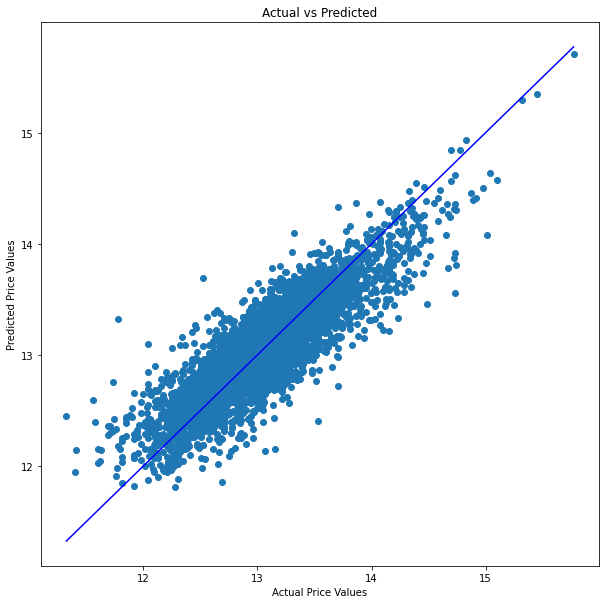

In [118]:
predicted_vs_actual(model3_20, X_test[key_cols['key_cols_20']], y_test)

In [119]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model3_20_ols = sm.OLS(y_train, X_train).fit()

In [120]:
model3_20_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1175.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:11:11   Log-Likelihood:                 5457.7
No. Observations:               17277   AIC:                        -1.068e+04
Df Residuals:                   17160   BIC:                            -9774.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -146.9238     15.517     -9.468      0.000    -177.339    -116.508
bedrooms            -0.0473      0.007     -7.065      0.000      -0.060      -0.034
bathrooms            0.0574      0.006      8.861      0.000       0.045       0.070
sqft_living          0.2774      0.019     14.260      0.000       0.239       0.316
sqft_lot             0.0742      0.004     18.479      0.000       0.066       0.082
sqft_above           0.1551      0.017      8.916      0.000       0.121       0.189
sqft_basement     1.058e-05   9.11e-06      1.161      0.246   -7.28e-06    2.84e-05
lat                 25.8726      3.716      6.963      0.000      18.589      33.156
long                -0.4488      0.056     -8.044      0.000      -0.558      -0.339
sqft_living15        0.1561      0.007     20.974      0.000       0.142       0.171
sqft_lot15          -0.0222      0.004     -5.039      0.000      -0.031      -0.014
age_of_house     -8.445e-06   8.86e-05     -0.095      0.924      -0.000       0.000
floors_1_5           0.0053      0.006      0.941      0.347      -0.006       0.016
floors_2_0          -0.0082      0.005     -1.692      0.091      -0.018       0.001
floors_2_5           0.0040      0.017      0.237      0.813      -0.029       0.037
floors_3_0          -0.0809      0.010     -7.729      0.000      -0.101      -0.060
floors_3_5          -0.0686      0.067     -1.017      0.309      -0.201       0.064
waterfront_1         0.4597      0.020     22.666      0.000       0.420       0.500
view_1               0.1229      0.011     10.736      0.000       0.100       0.145
view_2               0.0986      0.007     14.162      0.000       0.085       0.112
view_3               0.1735      0.010     18.152      0.000       0.155       0.192
view_4               0.2841      0.014     20.298      0.000       0.257       0.311
condition_2          0.1455      0.044      3.329      0.001       0.060       0.231
condition_3          0.2603      0.041      6.316      0.000       0.179       0.341
condition_4          0.3029      0.041      7.347      0.000       0.222       0.384
condition_5          0.3719      0.041      8.976      0.000       0.291       0.453
grade_4             -0.6112      0.182     -3.352      0.001      -0.969      -0.254
grade_5             -0.5339      0.178     -2.996      0.003      -0.883      -0.185
grade_6             -0.4858      0.178     -2.732      0.006      -0.834      -0.137
grade_7             -0.4167      0.178     -2.343      0.019      -0.765      -0.068
grade_8             -0.3372      0.178     -1.895      0.058      -0.686       0.012
grade_9             -0.2207      0.178     -1.239      0.215      -0.570       0.128
grade_10            -0.1295      0.178     -0.727      0.467      -0.479       0.220
grade_11            -0.


 Jarque-Bera ----
5395.9703804465325

 Prob ----
0.0

 Skew ----
-0.212947932614161

 Kurtosis ----
5.704499464923025


<ipython-input-38-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


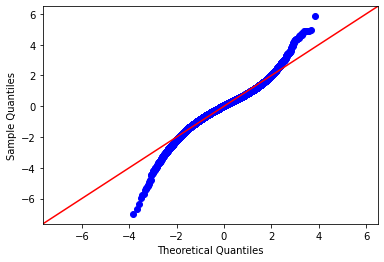

In [121]:
#test for normality
normality_test(model3_20_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.656417e+03
p-value                        1.176872e-270
f-value                         1.568671e+01
f p-value                      1.298747e-286

 Goldfeld-Quandt test ----
                value
F statistic  0.971864
p-value      0.906125

 Residuals plot ----


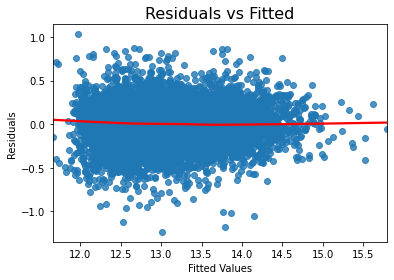

In [122]:
#test for homoscedasticity
homoscedasticity_test(model3_20_ols)

### Model 3: Testing 50 Features

In [123]:
#create linear regression model for price and setting up cross validation (x3)
model3_50 = LinearRegression()
model3_50.fit(X_train[key_cols['key_cols_50']], y_train);

In [124]:
#setting up cross validation for price in a different way (x3)
model3_50_cval = cross_val(model3_50,
                           X=X_train[key_cols['key_cols_50']],
                           y=y_train,
                           random_state=0,)

model3_50_cval_summary = cval_summary(model3_50_cval[0],
                                      model3_50_cval[1],
                                      abs(model3_50_cval[0]-model3_50_cval[1]))

model3_50_cval_summary

'The median R-squared values for the train sets were 0.86, the median R-squared values for the test sets were 0.859. These values resulted in a differential of 0.001'

In [125]:
#find the test score using the linear model
model3_50_scores = score_model(model3_50,
                               X_train[key_cols['key_cols_50']],
                               X_test[key_cols['key_cols_50']],
                               y_train,
                               y_test,
                               log=True)

model3_50_summary = model_summary(model3_50_scores[0],
                                  model3_50_scores[1],
                                  abs(model3_50_scores[0]-model3_50_scores[1]),
                                  model3_50_scores[2])
model3_50_summary

'The R-squared value for the train set was 0.86, and the R-sqaured value for the test set was 0.854. These values resulted in a differential of 0.00588. The RMSE of our model predicitons was 139548.54'

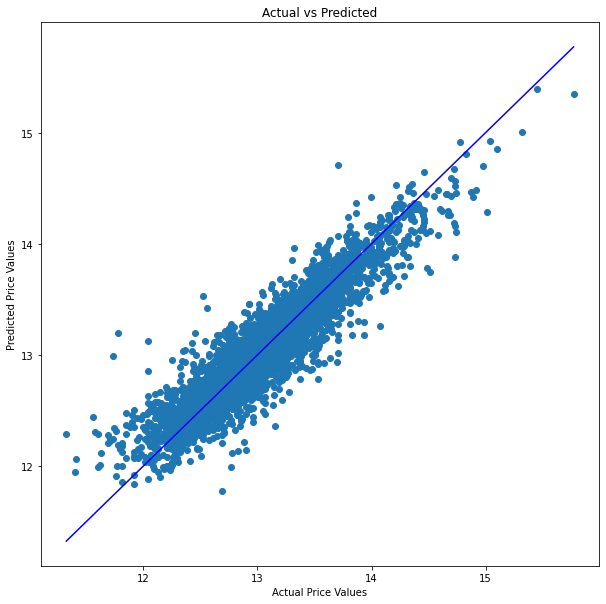

In [126]:
predicted_vs_actual(model3_50, X_test[key_cols['key_cols_50']], y_test)

In [127]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model3_50_ols = sm.OLS(y_train, X_train).fit()

In [128]:
model3_50_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1175.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:11:54   Log-Likelihood:                 5457.7
No. Observations:               17277   AIC:                        -1.068e+04
Df Residuals:                   17160   BIC:                            -9774.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -146.9238     15.517     -9.468      0.000    -177.339    -116.508
bedrooms            -0.0473      0.007     -7.065      0.000      -0.060      -0.034
bathrooms            0.0574      0.006      8.861      0.000       0.045       0.070
sqft_living          0.2774      0.019     14.260      0.000       0.239       0.316
sqft_lot             0.0742      0.004     18.479      0.000       0.066       0.082
sqft_above           0.1551      0.017      8.916      0.000       0.121       0.189
sqft_basement     1.058e-05   9.11e-06      1.161      0.246   -7.28e-06    2.84e-05
lat                 25.8726      3.716      6.963      0.000      18.589      33.156
long                -0.4488      0.056     -8.044      0.000      -0.558      -0.339
sqft_living15        0.1561      0.007     20.974      0.000       0.142       0.171
sqft_lot15          -0.0222      0.004     -5.039      0.000      -0.031      -0.014
age_of_house     -8.445e-06   8.86e-05     -0.095      0.924      -0.000       0.000
floors_1_5           0.0053      0.006      0.941      0.347      -0.006       0.016
floors_2_0          -0.0082      0.005     -1.692      0.091      -0.018       0.001
floors_2_5           0.0040      0.017      0.237      0.813      -0.029       0.037
floors_3_0          -0.0809      0.010     -7.729      0.000      -0.101      -0.060
floors_3_5          -0.0686      0.067     -1.017      0.309      -0.201       0.064
waterfront_1         0.4597      0.020     22.666      0.000       0.420       0.500
view_1               0.1229      0.011     10.736      0.000       0.100       0.145
view_2               0.0986      0.007     14.162      0.000       0.085       0.112
view_3               0.1735      0.010     18.152      0.000       0.155       0.192
view_4               0.2841      0.014     20.298      0.000       0.257       0.311
condition_2          0.1455      0.044      3.329      0.001       0.060       0.231
condition_3          0.2603      0.041      6.316      0.000       0.179       0.341
condition_4          0.3029      0.041      7.347      0.000       0.222       0.384
condition_5          0.3719      0.041      8.976      0.000       0.291       0.453
grade_4             -0.6112      0.182     -3.352      0.001      -0.969      -0.254
grade_5             -0.5339      0.178     -2.996      0.003      -0.883      -0.185
grade_6             -0.4858      0.178     -2.732      0.006      -0.834      -0.137
grade_7             -0.4167      0.178     -2.343      0.019      -0.765      -0.068
grade_8             -0.3372      0.178     -1.895      0.058      -0.686       0.012
grade_9             -0.2207      0.178     -1.239      0.215      -0.570       0.128
grade_10            -0.1295      0.178     -0.727      0.467      -0.479       0.220
grade_11            -0.


 Jarque-Bera ----
5395.9703804465325

 Prob ----
0.0

 Skew ----
-0.212947932614161

 Kurtosis ----
5.704499464923025


<ipython-input-38-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


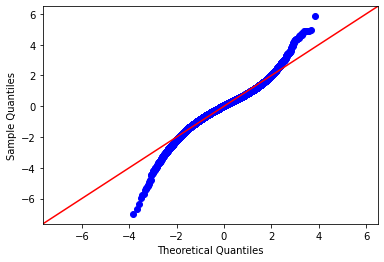

In [129]:
#test for normality
normality_test(model3_50_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.656417e+03
p-value                        1.176872e-270
f-value                         1.568671e+01
f p-value                      1.298747e-286

 Goldfeld-Quandt test ----
                value
F statistic  0.971864
p-value      0.906125

 Residuals plot ----


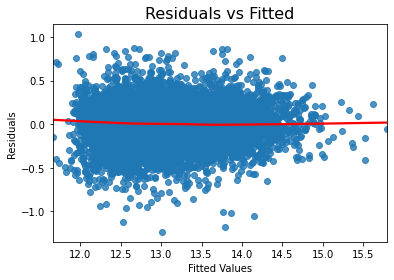

In [130]:
#test for homoscedasticity
homoscedasticity_test(model3_50_ols)

### Model 3: Testing 100 Features

In [131]:
#create linear regression model for price and setting up cross validation (x3)
model3_100 = LinearRegression()
model3_100.fit(X_train[key_cols['key_cols_100']], y_train);

In [132]:
#setting up cross validation for price in a different way (x3)
model3_100_cval = cross_val(model3_100,
                            X=X_train[key_cols['key_cols_100']],
                            y=y_train,
                            random_state=0,)

model3_100_cval_summary = cval_summary(model3_100_cval[0],
                                       model3_100_cval[1],
                                       abs(model3_100_cval[0]-model3_100_cval[1]))

model3_100_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.886. These values resulted in a differential of 0.00184'

In [133]:
#find the test score using the linear model
model3_100_scores = score_model(model3_100,
                                X_train[key_cols['key_cols_100']],
                                X_test[key_cols['key_cols_100']],
                                y_train,
                                y_test,
                                log=True)

model3_100_summary = model_summary(model3_100_scores[0],
                                   model3_100_scores[1],
                                   abs(model3_100_scores[0]-model3_100_scores[1]),
                                   model3_100_scores[2])
model3_100_summary

'The R-squared value for the train set was 0.888, and the R-sqaured value for the test set was 0.885. These values resulted in a differential of 0.00355. The RMSE of our model predicitons was 123197.96'

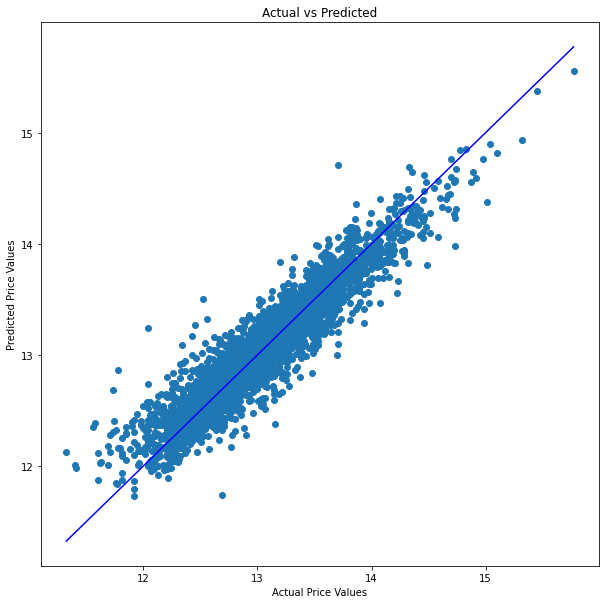

In [134]:
predicted_vs_actual(model3_100, X_test[key_cols['key_cols_100']], y_test)

In [135]:
#add constant to X_train
X_train = sm.add_constant(X_train)

#find OLS for train data set
model3_100_ols = sm.OLS(y_train, X_train).fit()

In [136]:
model3_100_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1175.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:12:36   Log-Likelihood:                 5457.7
No. Observations:               17277   AIC:                        -1.068e+04
Df Residuals:                   17160   BIC:                            -9774.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -146.9238     15.517     -9.468      0.000    -177.339    -116.508
bedrooms            -0.0473      0.007     -7.065      0.000      -0.060      -0.034
bathrooms            0.0574      0.006      8.861      0.000       0.045       0.070
sqft_living          0.2774      0.019     14.260      0.000       0.239       0.316
sqft_lot             0.0742      0.004     18.479      0.000       0.066       0.082
sqft_above           0.1551      0.017      8.916      0.000       0.121       0.189
sqft_basement     1.058e-05   9.11e-06      1.161      0.246   -7.28e-06    2.84e-05
lat                 25.8726      3.716      6.963      0.000      18.589      33.156
long                -0.4488      0.056     -8.044      0.000      -0.558      -0.339
sqft_living15        0.1561      0.007     20.974      0.000       0.142       0.171
sqft_lot15          -0.0222      0.004     -5.039      0.000      -0.031      -0.014
age_of_house     -8.445e-06   8.86e-05     -0.095      0.924      -0.000       0.000
floors_1_5           0.0053      0.006      0.941      0.347      -0.006       0.016
floors_2_0          -0.0082      0.005     -1.692      0.091      -0.018       0.001
floors_2_5           0.0040      0.017      0.237      0.813      -0.029       0.037
floors_3_0          -0.0809      0.010     -7.729      0.000      -0.101      -0.060
floors_3_5          -0.0686      0.067     -1.017      0.309      -0.201       0.064
waterfront_1         0.4597      0.020     22.666      0.000       0.420       0.500
view_1               0.1229      0.011     10.736      0.000       0.100       0.145
view_2               0.0986      0.007     14.162      0.000       0.085       0.112
view_3               0.1735      0.010     18.152      0.000       0.155       0.192
view_4               0.2841      0.014     20.298      0.000       0.257       0.311
condition_2          0.1455      0.044      3.329      0.001       0.060       0.231
condition_3          0.2603      0.041      6.316      0.000       0.179       0.341
condition_4          0.3029      0.041      7.347      0.000       0.222       0.384
condition_5          0.3719      0.041      8.976      0.000       0.291       0.453
grade_4             -0.6112      0.182     -3.352      0.001      -0.969      -0.254
grade_5             -0.5339      0.178     -2.996      0.003      -0.883      -0.185
grade_6             -0.4858      0.178     -2.732      0.006      -0.834      -0.137
grade_7             -0.4167      0.178     -2.343      0.019      -0.765      -0.068
grade_8             -0.3372      0.178     -1.895      0.058      -0.686       0.012
grade_9             -0.2207      0.178     -1.239      0.215      -0.570       0.128
grade_10            -0.1295      0.178     -0.727      0.467      -0.479       0.220
grade_11            -0.


 Jarque-Bera ----
5395.9703804465325

 Prob ----
0.0

 Skew ----
-0.212947932614161

 Kurtosis ----
5.704499464923025


<ipython-input-38-5ce98b0d5f74>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


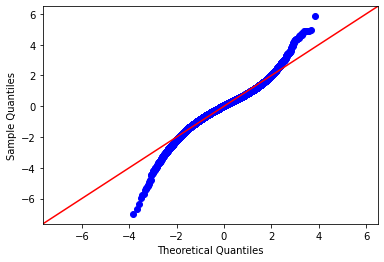

In [137]:
#test for normality
normality_test(model3_100_ols)


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.656417e+03
p-value                        1.176872e-270
f-value                         1.568671e+01
f p-value                      1.298747e-286

 Goldfeld-Quandt test ----
                value
F statistic  0.971864
p-value      0.906125

 Residuals plot ----


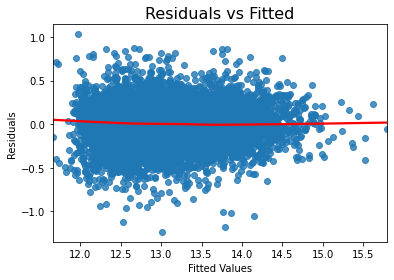

In [138]:
#test for homoscedasticity
homoscedasticity_test(model3_100_ols)

### Model 3: Summary

In [139]:
print(f"10 features {model3_10_scores,(model3_10_scores[0]-model3_10_scores[1]),model3_10_scores[2]}"),
print(f"20 features {model3_20_scores,(model3_20_scores[0]-model3_20_scores[1]),model3_20_scores[2]}"),
print(f"50 features {model3_50_scores,(model3_50_scores[0]-model3_50_scores[1]),model3_50_scores[2]}"),
print(f"100 features {model3_100_scores,(model3_100_scores[0]-model3_100_scores[1]),model3_100_scores[2]}"),
print(f" Previous Best Model{model1_ln_scores,(model1_ln_scores[0]-model1_ln_scores[1],model1_ln_scores[2])}")

10 features ((0.7123611922720557, 0.7072726750549063, 192974.66288015796), 0.005088517217149424, 192974.66288015796)
20 features ((0.7729484932511164, 0.7619555439292492, 171075.7426432362), 0.010992949321867118, 171075.7426432362)
50 features ((0.8599459271865626, 0.8540682407154585, 139548.54065995503), 0.005877686471104093, 139548.54065995503)
100 features ((0.8881025021450206, 0.8845530288416648, 123197.96206546141), 0.0035494733033558656, 123197.96206546141)
 Previous Best Model((0.9245124883208133, 0.8844790550146948, 123300.24706961555), (0.04003343330611853, 123300.24706961555))


Looking at the score results above it becomes apparent that the trade off for removing features from our original model is a reduced R-squared statistic. It is interesting to note however, that although the 100 feature model's r-squared statistic worsened by a minisule amount, the differental between train and test was also more narrow. This trend continues down to 50 features and then the differential begins to rise again signaling that there may be some "best" number of features for balance between r-squared and the spread between test and train.

## Model 4

insert descriptive text on Binomial Feature Engineering 

### Model 4: Binomial Feature Engineering

In [ ]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test(output_ln, 'ln_price')

#setting up binomial features from Train/Test split that uses ln_price as a y value
pf = PolynomialFeatures(degree=2)
pf.fit(X_train);

In [ ]:
#Training/tranforming the data using the fit pf object. Formatting as DataFrame for ease of use
pdf_train = pd.DataFrame(pf.transform(X_train), columns = pf.get_feature_names())
pdf_test = pd.DataFrame(pf.transform(X_test), columns = pf.get_feature_names())
pdf_train.index = y_train.index
pdf_test.index = y_test.index

### Model 4: Pearson Correlation Coefficient Filtering

In [ ]:
#calculating corr to the df with polynomial features to the train y values 
correlations = pdf_train.corrwith(y_train)
correlations_df = pd.DataFrame(correlations)
correlations_df.head()

In [ ]:
#NaN values represent columns containing 0 values, we wont need to consider these
correlations_df.dropna(inplace=True)

In [ ]:
#Mapping absolute value over the correlations_df to allow us to find the most impactful coefs
correlations_df[0].map(abs)
#Sorting them so that we can skim the best ones off the top
correlations_df.sort_values(by=0,ascending=False,inplace=True)

In [ ]:
#Column names of the top x number of features from our polynomial df, adding 1 to represent the intercept
features = list(correlations_df.index[:250]) + ['1']

### Model 4: Model Validation

In [ ]:
#instantiating a linear regression object
model4 = LinearRegression()
model4.fit(X = pdf_train[features], y = y_train);

In [ ]:
model4_cval = cross_val(model4,
                        X=pdf_train,
                        y=y_train,
                        random_state=0,)

model4_cval_summary = cval_summary(model4_cval[0],
                                   model4_cval[1],
                                   abs(model4_cval[0]-model4_cval[1]))

model4_cval_summary

In [ ]:
model4_scores = score_model(model4,
                            pdf_train[features],
                            pdf_test[features],
                            y_train,
                            y_test,
                            log=True)

model4_summary = model_summary(model4_scores[0],
                               model4_scores[1],
                               abs(model4_scores[0]-model4_scores[1]),
                               model4_scores[2])
model4_summary

In [ ]:
predicted_vs_actual(model4, pdf_test[features], y_test)

### Model 4: OLS and Assumption Testing

In [ ]:
pdf_train_wconst = sm.add_constant(pdf_train[features])
model4_ols = sm.OLS(y_train,pdf_train_wconst).fit()

In [ ]:
model4_ols.summary()

In [ ]:
#test for normality
normality_test(model4_ols)

In [ ]:
#test for homoscedasticity
homoscedasticity_test(model4_ols)

### Model 4: Summary

This model works as a proof of concept but fails to significantly improve upon model 1 in order to warrant the significant increase in complexity. We will reject this model in favor of model 1.

## Conclusions